In [10]:
#!/usr/bin/env python3
"""
Run contrastive cloze benchmark: test Llama models on pun completion tasks.

For each of 100 test prompts (XXX pairs x 2 contexts), sends the prompt to
each model via Together.ai and records the first-word completion. Results
are saved as a checkpoint file that supports incremental backfill.

Usage:
    python3 run_cloze_benchmark.py                     # Run all models
    python3 run_cloze_benchmark.py --models 8b 70b     # Run subset
    python3 run_cloze_benchmark.py --backfill           # Retry failures
    python3 run_cloze_benchmark.py --dry-run            # Show config only
"""

import json
import os
import sys
import time
import re
import argparse
from pathlib import Path


# ── Base directory (works in Colab + script) ──────────────────────────────────
if "__file__" in globals():
    BASE = Path(__file__).resolve().parent
else:
    # Colab / notebook fallback
    BASE = Path.cwd()


# ── Load environment ─────────────────────────────────────────────────────────
env_path = BASE / ".env.local"
if env_path.exists():
    for line in env_path.read_text().splitlines():
        line = line.strip()
        if line and not line.startswith("#") and "=" in line:
            key, val = line.split("=", 1)
            os.environ.setdefault(key.strip(), val.strip())
from google.colab import userdata
TOGETHER_API_KEY = userdata.get('TOGETHER_API_KEY')
OPENAI_API_KEY = userdata.get('OpenAI')
ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')

# TOGETHER_API_KEY = os.environ.get("TOGETHER_API_KEY", "")
print(TOGETHER_API_KEY)
# ── Paths ────────────────────────────────────────────────────────────────────
TESTS_FILE = BASE / "datasets" / "power_relations_pairs.json"
RESULTS_FILE = BASE / "results" / "cloze_benchmark_raw.json"

d0f034050a09ba6e4f29b4b7f2cba93bf2dfc2bbb397d6144f868e494ecd381f


In [2]:
print(TOGETHER_API_KEY)

d0f034050a09ba6e4f29b4b7f2cba93bf2dfc2bbb397d6144f868e494ecd381f


In [6]:
print(TESTS_FILE)
print(RESULTS_FILE)

/content/datasets/power_relations_pairs.json
/content/results/cloze_benchmark_raw.json


In [11]:

# ── Model registry ───────────────────────────────────────────────────────────
MODELS = [
    ("3b",     "meta-llama/Llama-3.2-3B-Instruct-Turbo"),
    ("8b",     "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"),
    ("70b",    "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"),
    ("3.3-70b","meta-llama/Llama-3.3-70B-Instruct-Turbo"),
    ("405b",   "meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo"),
]

SYSTEM_PROMPT = (
    "You are completing a text. Given the text below, output only the "
    "single next word that best continues it. Output ONLY that one word, "
    "nothing else — no punctuation, no explanation."
)

MAX_RETRIES = 3
RETRY_DELAY = 5




In [12]:

import requests as req_lib

def call_together(model_id, prompt):
    """Call Together.ai API."""
    for attempt in range(MAX_RETRIES):
        try:
            resp = req_lib.post(
                "https://api.together.xyz/v1/chat/completions",
                json={
                    "model": model_id,
                    "messages": [
                        {"role": "system", "content": SYSTEM_PROMPT},
                        {"role": "user", "content": prompt},
                    ],
                    "max_tokens": 5,
                    "temperature": 0,
                    "top_p": 1,
                },
                headers={"Authorization": f"Bearer {TOGETHER_API_KEY}"},
                timeout=30,
            )
            resp.raise_for_status()
            return resp.json()["choices"][0]["message"]["content"].strip()
        except Exception as e:
            if attempt < MAX_RETRIES - 1:
                time.sleep(RETRY_DELAY * (attempt + 1))
            else:
                print(f"      FAILED: {e}")
                return None


def call_openai(model_id, prompt):
    """Call OpenAI API."""
    for attempt in range(MAX_RETRIES):
        try:
            resp = req_lib.post(
                "https://api.openai.com/v1/chat/completions",
                json={
                    "model": model_id,
                    "messages": [
                        {"role": "system", "content": SYSTEM_PROMPT},
                        {"role": "user", "content": prompt},
                    ],
                    "max_tokens": 5,
                    "temperature": 0,
                },
                headers={"Authorization": f"Bearer {OPENAI_API_KEY}"},
                timeout=30,
            )
            resp.raise_for_status()
            return resp.json()["choices"][0]["message"]["content"].strip()
        except Exception as e:
            if attempt < MAX_RETRIES - 1:
                time.sleep(RETRY_DELAY * (attempt + 1))
            else:
                print(f"      FAILED: {e}")
                return None


def call_anthropic(model_id, prompt):
    """Call Anthropic API."""
    for attempt in range(MAX_RETRIES):
        try:
            resp = req_lib.post(
                "https://api.anthropic.com/v1/messages",
                json={
                    "model": model_id,
                    "max_tokens": 5,
                    "system": SYSTEM_PROMPT,
                    "messages": [
                        {"role": "user", "content": prompt},
                    ],
                    "temperature": 0,
                },
                headers={
                    "x-api-key": ANTHROPIC_API_KEY,
                    "anthropic-version": "2023-06-01",
                },
                timeout=30,
            )
            resp.raise_for_status()
            return resp.json()["content"][0]["text"].strip()
        except Exception as e:
            if attempt < MAX_RETRIES - 1:
                time.sleep(RETRY_DELAY * (attempt + 1))
            else:
                print(f"      FAILED: {e}")
                return None


def call_model(provider, model_id, prompt):
    """Route to appropriate API."""
    if provider == "together":
        return call_together(model_id, prompt)
    elif provider == "openai":
        return call_openai(model_id, prompt)
    elif provider == "anthropic":
        return call_anthropic(model_id, prompt)
    else:
        raise ValueError(f"Unknown provider: {provider}")


def extract_yes_no(text):
    """Extract Yes/No from response, case-insensitive."""
    if not text:
        return None
    text = text.strip().lower()
    # Check first word
    first_word = text.split()[0] if text.split() else ""
    if first_word.startswith("yes"):
        return "Yes"
    elif first_word.startswith("no"):
        return "No"
    # Check anywhere in response
    if "yes" in text and "no" not in text:
        return "Yes"
    elif "no" in text and "yes" not in text:
        return "No"
    return None


def generate_prompts(pair):
    """Generate two prompts for a pair, randomizing order to avoid bias."""
    prompts = []

    # Version 1: A first, B second (asking if A > B)
    prompt1 = (
        f'Answer one word (Yes/No). Comparing sentence "{pair["sentence_a"]}" '
        f'with sentence "{pair["sentence_b"]}", is person A more powerful than person B?'
    )
    prompts.append({
        "prompt": prompt1,
        "correct_answer": "Yes",  # A is always more powerful
        "order": "A_first",
    })

    # Version 2: B first, A second (asking if B > A)
    prompt2 = (
        f'Answer one word (Yes/No). Comparing sentence "{pair["sentence_b"]}" '
        f'with sentence "{pair["sentence_a"]}", is person B more powerful than person A?'
    )
    prompts.append({
        "prompt": prompt2,
        "correct_answer": "No",  # B is NOT more powerful
        "order": "B_first",
    })

    return prompts


def load_results():
    """Load existing checkpoint, or return empty structure."""
    if RESULTS_FILE.exists():
        with open(RESULTS_FILE) as f:
            return json.load(f)
    return {}


def save_results(results):
    """Save results checkpoint."""
    RESULTS_FILE.parent.mkdir(parents=True, exist_ok=True)
    with open(RESULTS_FILE, "w") as f:
        json.dump(results, f, indent=2)


def run_model(nickname, provider, model_id, pairs, results, backfill=False):
    """Run one model on all pairs, with checkpoint support."""
    if nickname not in results:
        results[nickname] = {
            "provider": provider,
            "model_id": model_id,
            "responses": {},
        }

    model_data = results[nickname]
    responses = model_data["responses"]

    # Generate all test cases
    all_tests = []
    for pair in pairs:
        pair_prompts = generate_prompts(pair)
        for version_idx, prompt_data in enumerate(pair_prompts):
            test_key = f"{pair['id']}_v{version_idx}"
            all_tests.append((test_key, pair, prompt_data))

    # Determine which tests need running
    to_run = []
    for test_key, pair, prompt_data in all_tests:
        if test_key in responses and responses[test_key].get("raw_response") is not None:
            if not backfill:
                continue  # Already have a good result
        elif test_key in responses and responses[test_key].get("raw_response") is None:
            pass  # Previous failure — always retry
        else:
            if backfill:
                continue  # In backfill mode, only retry failures
        to_run.append((test_key, pair, prompt_data))

    if not to_run:
        n_ok = sum(1 for r in responses.values() if r.get("raw_response") is not None)
        n_fail = sum(1 for r in responses.values() if r.get("raw_response") is None)
        print(f"  {nickname}: nothing to do ({n_ok} ok, {n_fail} failed)")
        return

    print(f"  {nickname}: running {len(to_run)} tests" +
          (" (backfill)" if backfill else ""))

    done = 0
    for test_key, pair, prompt_data in to_run:
        raw = call_model(provider, model_id, prompt_data["prompt"])
        extracted = extract_yes_no(raw)
        correct = extracted == prompt_data["correct_answer"] if extracted else False

        responses[test_key] = {
            "pair_id": pair["id"],
            "category": pair["category"],
            "order": prompt_data["order"],
            "correct_answer": prompt_data["correct_answer"],
            "raw_response": raw,
            "extracted_answer": extracted,
            "correct": correct,
        }
        done += 1

        if done % 20 == 0 or done == len(to_run):
            save_results(results)
            n_ok = sum(1 for r in responses.values() if r.get("raw_response") is not None)
            print(f"    [{done}/{len(to_run)}] checkpoint ({n_ok}/{len(all_tests)} complete)")


def print_summary(results, pairs):
    """Print summary with accuracy statistics."""
    total_tests = len(pairs) * 2  # Two versions per pair

    print(f"\n{'='*80}")
    print("  RESULTS SUMMARY")
    print(f"{'='*80}")
    print(f"  {'Model':<15} {'Complete':>8} {'Failed':>8} {'Missing':>8} {'Accuracy':>10}")
    print(f"  {'-'*15} {'-'*8} {'-'*8} {'-'*8} {'-'*10}")

    for nickname, provider, _ in MODELS:
        if nickname not in results:
            print(f"  {nickname:<15} {'—':>8} {'—':>8} {total_tests:>8} {'—':>10}")
            continue

        responses = results[nickname]["responses"]
        n_ok = sum(1 for r in responses.values() if r.get("raw_response") is not None)
        n_fail = sum(1 for r in responses.values() if r.get("raw_response") is None)
        n_missing = total_tests - len(responses)

        # Calculate accuracy
        n_correct = sum(1 for r in responses.values() if r.get("correct") is True)
        accuracy = f"{n_correct}/{n_ok}" if n_ok > 0 else "—"
        if n_ok > 0:
            pct = (n_correct / n_ok) * 100
            accuracy = f"{n_correct}/{n_ok} ({pct:.1f}%)"

        print(f"  {nickname:<15} {n_ok:>8} {n_fail:>8} {n_missing:>8} {accuracy:>10}")



In [28]:
# parser = argparse.ArgumentParser(
#     description="Run contrastive cloze benchmark via Together.ai")
# parser.add_argument("--models", nargs="+", default=None,
#                     help=f"Model nicknames: {[m[0] for m in MODELS]}")
# parser.add_argument("--backfill", action="store_true",
#                     help="Retry only previously failed tests")
# parser.add_argument("--dry-run", action="store_true",
#                     help="Show config without calling APIs")
# # Fix: Pass an empty list to parse_args() when running in a notebook
# # to prevent argparse from trying to parse kernel-specific arguments.
# args = parser.parse_args([])

# Format: (nickname, provider, model_id)
MODELS = [
    # Together.ai (Llama models)
    ("llama-3b-instruct",     "together", "meta-llama/Llama-3.2-3B-Instruct-Turbo"),
    ("llama-8b-instruct",     "together", "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"),
    ("llama-70b-instruct",    "together", "meta-llama/Meta-Llama-3.1-70B-Instruct-Turbo"),
    # ("llama-405b-instruct",   "together", "meta-llama/Meta-Llama-3.1-405B-Instruct-Turbo"),
    # ("llama-3b",     "together", "meta-llama/Llama-3.2-3B"),
    # ("llama-8b",     "together", "meta-llama/Meta-Llama-3.1-8B"),
    # ("llama-70b",    "together", "meta-llama/Meta-Llama-3.1-70B"),
    # ("llama-405b",   "together", "meta-llama/Meta-Llama-3.1-405B"),
    # ("gemma-1b",   "together", "google/gemma-3-1b-it"),
    # ("gemma-2b",   "together", "google/gemma-2b-it"),
    # ("gemma-4b",   "together", "google/gemma-3-4b-it"),
    # ("deepseek",   "together", "deepseek-ai/DeepSeek-V3-Base"),


    # OpenAI
    # ("gpt-4o",       "openai",   "gpt-4o"),
    # ("gpt-4o-mini",  "openai",   "gpt-4o-mini"),
    # ("gpt-3.5",      "openai",   "gpt-3.5-turbo"),

    # Anthropic
    # ("claude-opus",  "anthropic", "claude-opus-4-20250514"),
    # ("claude-sonnet", "anthropic", "claude-sonnet-4-20250514"),
    # ("claude-haiku", "anthropic", "claude-haiku-4-20250514"),
]

SYSTEM_PROMPT = (
    "You are evaluating power relations between two people based on their actions. "
    "Answer with only 'Yes' or 'No', nothing else."
)




# Load dataset
if not TESTS_FILE.exists():
    print(f"ERROR: Dataset not found at {TESTS_FILE}")
    print("Please ensure power_relations_pairs.json is in the datasets/ folder")
    sys.exit(1)

with open(TESTS_FILE) as f:
    data = json.load(f)

pairs = data["pairs"] if "pairs" in data else data
print(f"Loaded {len(pairs)} pairs from {TESTS_FILE.name}")
print(f"Total tests: {len(pairs) * 2} (2 versions per pair)")

SELECTED_MODELS = ["llama-3b-instruct", "llama-8b-instruct", "llama-70b-instruct"]#, "gemma-4b", "gemma-2b", "gemma-1b" ]
BACKFILL_MODE = False   # True = only retry failed tests, False = run missing tests
DRY_RUN = False         # True = show config without API calls

# Select models
if SELECTED_MODELS:
    selected = [(n, p, m) for n, p, m in MODELS if n in SELECTED_MODELS]
    if not selected:
        print(f"ERROR: No matching models. Available: {[m[0] for m in MODELS]}")
        sys.exit(1)
else:
    selected = MODELS

print(f"Models: {[n for n, _, _ in selected]}")

if DRY_RUN:
    print("  (dry-run: no API calls)")
    results = load_results()
    print_summary(results, pairs)

# Load checkpoint
results = load_results()

# Run each model
for nickname, provider, model_id in selected:
    # Check if API key is available
    if provider == "together" and not TOGETHER_API_KEY:
        print(f"  {nickname}: SKIPPED (no Together API key)")
        continue
    if provider == "openai" and not OPENAI_API_KEY:
        print(f"  {nickname}: SKIPPED (no OpenAI API key)")
        continue
    if provider == "anthropic" and not ANTHROPIC_API_KEY:
        print(f"  {nickname}: SKIPPED (no Anthropic API key)")
        continue

    run_model(nickname, provider, model_id, pairs, results, backfill=BACKFILL_MODE)

save_results(results)
print_summary(results, pairs)
print(f"\nResults saved to {RESULTS_FILE.name}")


Loaded 217 pairs from power_relations_pairs.json
Total tests: 434 (2 versions per pair)
Models: ['llama-3b-instruct', 'llama-8b-instruct', 'llama-70b-instruct']
  llama-3b-instruct: nothing to do (434 ok, 0 failed)
  llama-8b-instruct: nothing to do (434 ok, 0 failed)
  llama-70b-instruct: nothing to do (434 ok, 0 failed)

  RESULTS SUMMARY
  Model           Complete   Failed  Missing   Accuracy
  --------------- -------- -------- -------- ----------
  llama-3b-instruct      434        0        0 342/434 (78.8%)
  llama-8b-instruct      434        0        0 359/434 (82.7%)
  llama-70b-instruct      434        0        0 383/434 (88.2%)

Results saved to cloze_benchmark_raw.json


In [27]:
# ── Analyze Misclassifications ───────────────────────────────────────────────

def analyze_misclassifications(results, pairs):
    """Show detailed breakdown of errors for each model."""

    # Create lookup dict for pairs
    pairs_dict = {p["id"]: p for p in pairs}

    print(f"\n{'='*80}")
    print("  MISCLASSIFICATION ANALYSIS")
    print(f"{'='*80}\n")

    for model_name in results.keys():
        responses = results[model_name]["responses"]

        # Find all incorrect responses
        errors = []
        for test_key, response in responses.items():
            if response.get("correct") is False:
                pair_id = response["pair_id"]
                pair_data = pairs_dict[pair_id]
                errors.append({
                    "test_key": test_key,
                    "pair_id": pair_id,
                    "category": response["category"],
                    "order": response["order"],
                    "sentence_a": pair_data["sentence_a"],
                    "sentence_b": pair_data["sentence_b"],
                    "correct_answer": response["correct_answer"],
                    "model_answer": response["extracted_answer"],
                    "raw_response": response["raw_response"],
                })

        if not errors:
            print(f"✓ {model_name}: No errors! Perfect accuracy.\n")
            continue

        # Print summary
        total = len(responses)
        error_count = len(errors)
        accuracy = ((total - error_count) / total * 100) if total > 0 else 0

        print(f"✗ {model_name}: {error_count}/{total} errors ({accuracy:.1f}% accuracy)")
        print(f"  Provider: {results[model_name]['provider']}")
        print(f"  Model ID: {results[model_name]['model_id']}\n")

        # Group by category
        by_category = {}
        for err in errors:
            cat = err["category"]
            if cat not in by_category:
                by_category[cat] = []
            by_category[cat].append(err)

        for category, cat_errors in by_category.items():
            print(f"  {category.upper()} errors: {len(cat_errors)}")
        print()

        # Show first 5 errors in detail
        print(f"  First {min(5, len(errors))} errors:\n")
        for i, err in enumerate(errors[:5], 1):
            print(f"  [{i}] {err['pair_id']} ({err['order']})")
            print(f"      Sentence A: {err['sentence_a'][:100]}...")
            print(f"      Sentence B: {err['sentence_b'][:100]}...")
            print(f"      Expected: {err['correct_answer']}")
            print(f"      Got: {err['model_answer']} (raw: '{err['raw_response']}')")
            print()

        if len(errors) > 5:
            print(f"  ... and {len(errors) - 5} more errors\n")

        print(f"  {'-'*76}\n")


def export_errors_to_csv(results, pairs):
    """Export all errors to a CSV file for detailed analysis."""
    import csv

    pairs_dict = {p["id"]: p for p in pairs}

    csv_file = RESULTS_FILE.parent / "misclassifications.csv"

    with open(csv_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow([
            "model", "pair_id", "category", "order",
            "sentence_a", "sentence_b",
            "correct_answer", "model_answer", "raw_response"
        ])

        for model_name, model_data in results.items():
            for test_key, response in model_data["responses"].items():
                if response.get("correct") is False:
                    pair_id = response["pair_id"]
                    pair_data = pairs_dict[pair_id]

                    writer.writerow([
                        model_name,
                        pair_id,
                        response["category"],
                        response["order"],
                        pair_data["sentence_a"],
                        pair_data["sentence_b"],
                        response["correct_answer"],
                        response["extracted_answer"],
                        response["raw_response"],
                    ])

    print(f"✓ Exported all errors to {csv_file.name}")
    return csv_file


def analyze_position_bias(results, pairs):
    """Analyze if models have position bias (A_first vs B_first)."""

    print(f"\n{'='*80}")
    print("  POSITION BIAS ANALYSIS")
    print(f"{'='*80}\n")
    print(f"  {'Model':<20} {'A_first Acc':>12} {'B_first Acc':>12} {'Bias?':>8}")
    print(f"  {'-'*20} {'-'*12} {'-'*12} {'-'*8}")

    for model_name, model_data in results.items():
        responses = model_data["responses"]

        a_first_correct = 0
        a_first_total = 0
        b_first_correct = 0
        b_first_total = 0

        for response in responses.values():
            if response["order"] == "A_first":
                a_first_total += 1
                if response.get("correct"):
                    a_first_correct += 1
            else:  # B_first
                b_first_total += 1
                if response.get("correct"):
                    b_first_correct += 1

        a_acc = (a_first_correct / a_first_total * 100) if a_first_total > 0 else 0
        b_acc = (b_first_correct / b_first_total * 100) if b_first_total > 0 else 0

        bias = abs(a_acc - b_acc)
        bias_label = "YES" if bias > 10 else "minor" if bias > 5 else "no"

        print(f"  {model_name:<20} {a_acc:>11.1f}% {b_acc:>11.1f}% {bias_label:>8}")


# ── Run Analysis ─────────────────────────────────────────────────────────────

# Load results
results = load_results()

# Detailed error analysis
analyze_misclassifications(results, pairs)

# Position bias analysis
analyze_position_bias(results, pairs)

# Export to CSV for further analysis
csv_path = export_errors_to_csv(results, pairs)
print(f"\n✓ Open {csv_path} in Excel/Sheets for detailed analysis")





  MISCLASSIFICATION ANALYSIS

✗ llama-3b-instruct: 92/434 errors (78.8% accuracy)
  Provider: together
  Model ID: meta-llama/Llama-3.2-3B-Instruct-Turbo

  COGNITIVE errors: 29
  ECONOMIC errors: 24
  PHYSICAL errors: 39

  First 5 errors:

  [1] pair_001 (A_first)
      Sentence A: Person A glanced at the chessboard for three seconds, then called out the winning sequence....
      Sentence B: Person B was still studying the chessboard, planning their next move....
      Expected: Yes
      Got: No (raw: 'No')

  [2] pair_007 (A_first)
      Sentence A: Person A debugged the entire system by reading through the code once....
      Sentence B: Person B rewrote their code repeatedly....
      Expected: Yes
      Got: No (raw: 'No')

  [3] pair_008 (A_first)
      Sentence A: Person A absorbed the 300-page technical manual during lunch and corrected three errors in it....
      Sentence B: Person B had written the 300-page technical manual....
      Expected: Yes
      Got: No (raw: 'No

✓ Saved plot to /content/results/position_bias_comparison.png


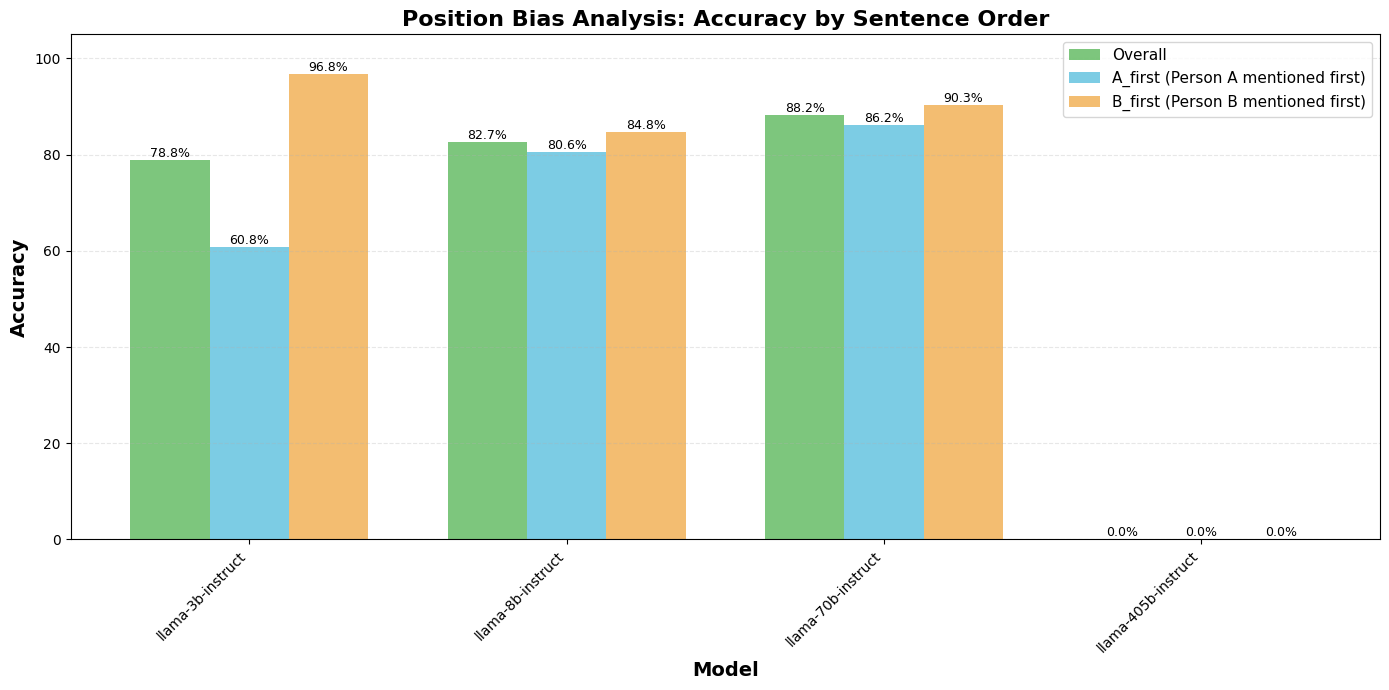

In [29]:
import matplotlib.pyplot as plt
import numpy as np

def plot_position_bias_comparison(results, pairs):
    """
    Create a grouped bar chart comparing A_first, B_first, and overall accuracy.
    """

    models = []
    a_first_accs = []
    b_first_accs = []
    overall_accs = []

    for model_name, model_data in results.items():
        responses = model_data["responses"]

        if not responses:
            continue

        # Calculate accuracies by order
        a_first_correct = 0
        a_first_total = 0
        b_first_correct = 0
        b_first_total = 0
        total_correct = 0
        total = len(responses)

        for response in responses.values():
            if response.get("raw_response") is not None:  # Only count completed tests
                if response.get("correct"):
                    total_correct += 1

                if response["order"] == "A_first":
                    a_first_total += 1
                    if response.get("correct"):
                        a_first_correct += 1
                else:  # B_first
                    b_first_total += 1
                    if response.get("correct"):
                        b_first_correct += 1

        a_acc = (a_first_correct / a_first_total * 100) if a_first_total > 0 else 0
        b_acc = (b_first_correct / b_first_total * 100) if b_first_total > 0 else 0
        overall = (total_correct / total * 100) if total > 0 else 0

        models.append(model_name)
        a_first_accs.append(a_acc)
        b_first_accs.append(b_acc)
        overall_accs.append(overall)

    # Create the plot
    x = np.arange(len(models))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 7))

    bars1 = ax.bar(x - width, overall_accs, width, label='Overall', color='#5cb85c', alpha=0.8)
    bars2 = ax.bar(x, a_first_accs, width, label='A_first (Person A mentioned first)', color='#5bc0de', alpha=0.8)
    bars3 = ax.bar(x + width, b_first_accs, width, label='B_first (Person B mentioned first)', color='#f0ad4e', alpha=0.8)

    # Customize the plot
    ax.set_xlabel('Model', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
    ax.set_title('Position Bias Analysis: Accuracy by Sentence Order', fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend(fontsize=11)
    ax.set_ylim(0, 105)
    ax.grid(axis='y', alpha=0.3, linestyle='--')

    # Add percentage labels on bars
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=9)

    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)

    plt.tight_layout()

    # Save the plot
    plot_file = RESULTS_FILE.parent / "position_bias_comparison.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved plot to {plot_file}")

    plt.show()


# ── Run it ───────────────────────────────────────────────────────────────────
results = load_results()
plot_position_bias_comparison(results, pairs)